<a href="https://colab.research.google.com/github/yoshioakio/Bicycle-rental-monitoring-dashboard/blob/main/image_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [Icons-50](https://www.kaggle.com/datasets/danhendrycks/icons50)
- **Nama:** Muhamad Fajri Permana Haryanto
- **Email:** muhamadfajri2804@gmail.com
- **ID Dicoding:** mijimo

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install -q kaggle

In [2]:
!pip install -q keras

In [3]:
!pip install -U tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow

In [4]:
!pip install split-folders

In [5]:
import os
import json
import splitfolders
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
print(tf.__version__)

2.19.0


## Data Preparation

### Data Loading

In [7]:
!mkdir -p ~/.kaggle
!echo '{"username":"fajriharyanto","key":"998acd734e359f906329500715f20f7e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle
!kaggle datasets download -d danhendrycks/icons50

Dataset URL: https://www.kaggle.com/datasets/danhendrycks/icons50
License(s): unknown


In [8]:
!unzip -q icons50.zip -d /content

In [9]:
!ls /content

icons-50  Icons-50  Icons-50.npy  icons50.zip  sample_data


### Data Preprocessing

In [10]:
import os
import json
import numpy as np
import pandas as pd
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
import splitfolders

#### Split Dataset

In [11]:
data_dir = '/content/icons-50/Icons-50'

In [12]:
base_dir = '/content/dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for dir in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

classes = os.listdir(data_dir)
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)

        train_split = int(0.8 * len(images))
        val_split = int(0.9 * len(images))

        train_images = images[:train_split]
        val_images = images[train_split:val_split]
        test_images = images[val_split:]

        for image in train_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(train_dir, class_name)
            os.makedirs(dst, exist_ok=True)
            shutil.copy(src, dst)

        for image in val_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(val_dir, class_name)
            os.makedirs(dst, exist_ok=True)
            shutil.copy(src, dst)

        for image in test_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(test_dir, class_name)
            os.makedirs(dst, exist_ok=True)
            shutil.copy(src, dst)

#### Augmentasi Data

In [13]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
).flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 7979 images belonging to 50 classes.
Found 1000 images belonging to 50 classes.
Found 1021 images belonging to 50 classes.


## Modelling

In [14]:
num_classes = len([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])

model = tf.keras.Sequential([
    Input(shape=(64, 64, 3)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,787,378 (33.52 MB)

 Trainable params: 8,786,482 (33.52 MB)

 Non-trainable params: 896 (3.50 KB)

## Evaluasi dan Visualisasi

In [15]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1)

checkpoint_path = 'best_model.keras'
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

target_accuracy = 0.975
class CustomAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= target_accuracy:
            print(f"Validation accuracy reached {target_accuracy}, stopping training.")
            self.model.stop_training = True

custom_accuracy_callback = CustomAccuracyCallback()

history = model.fit(
    train_generator,
    batch_size=15,
    epochs=40,
    validation_data=val_generator,
    callbacks=[early_stop, model_checkpoint, custom_accuracy_callback]
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2373 - loss: 3.4717
Epoch 1: val_accuracy improved from -inf to 0.10300, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.2376 - loss: 3.4694 - val_accuracy: 0.1030 - val_loss: 5.5872
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4450 - loss: 2.1755
Epoch 2: val_accuracy improved from 0.10300 to 0.59100, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.4450 - loss: 2.1752 - val_accuracy: 0.5910 - val_loss: 1.5483
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5185 - loss: 1.8534
Epoch 3: val_accuracy improved from 0.59100 to 0.70100, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.5185 - loss: 1.8531 - val_accuracy: 0.7010 - val_loss: 1.1153
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5849 - loss: 1.5797
Epoch 4: val_accuracy improved from 0.7010

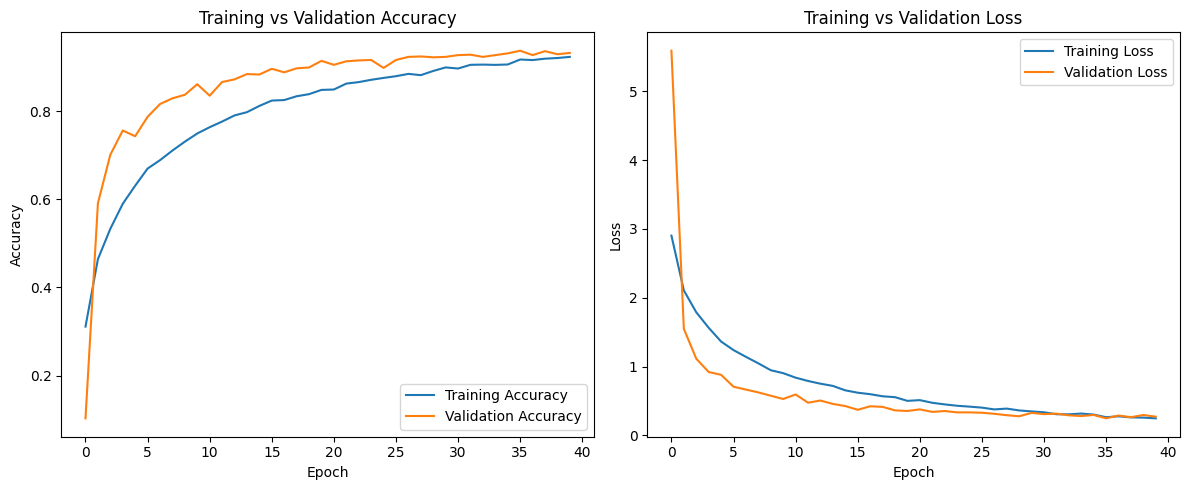

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc:.4f}")

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 275ms/step - accuracy: 0.9634 - loss: 0.1248
Training Accuracy: 0.9647
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.8896 - loss: 0.4783
Test Accuracy: 0.9089


## Konversi Model

### Menyimpan dalam Format SavedModel (standar TensorFlow)

In [18]:
model.save('model_savedmodel.keras')

### Menyimpan dalam Format TF-Lite

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpc7ukh25p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 50), dtype=tf.float32, name=None)
Captures:
  137229753810576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137229753810192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137226924249296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137226924251600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137226924249104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137226924251408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137226924249872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137226924251216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137226924250064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137226924249488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137226924251984

## Inference (Optional)

Saving apple_0_glowing_star.png to apple_0_glowing_star.png


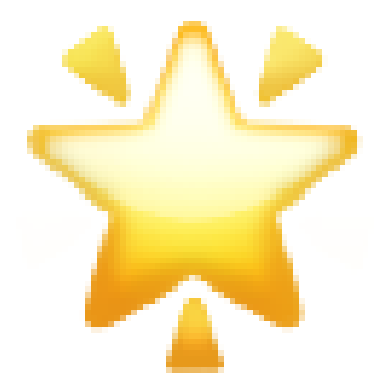

Predicted Class: star, Confidence: 100.00%


In [25]:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()
def load_image(image_path, target_size=(64, 64)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    return np.expand_dims(tf.keras.preprocessing.image.img_to_array(img), axis=0)
def get_class_names(train_dir):
    return sorted(os.listdir(train_dir))

def predict_image(image_path, class_names):
    input_data = load_image(image_path)

    input_details, output_details = interpreter.get_input_details(), interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    plt.imshow(input_data[0].astype(np.uint8))
    plt.axis('off')
    plt.show()
    predicted_class = np.argmax(output_data)
    print(f'Predicted Class: {class_names[predicted_class]}, Confidence: {np.max(output_data) * 100:.2f}%')

uploaded = files.upload()
image_path = next(iter(uploaded))

train_dir = '/content/dataset_split/train'
predict_image(image_path, get_class_names(train_dir))